In [1]:
import sys
sys.path.append('../Codes/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math
import json

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


## Generating Sequences

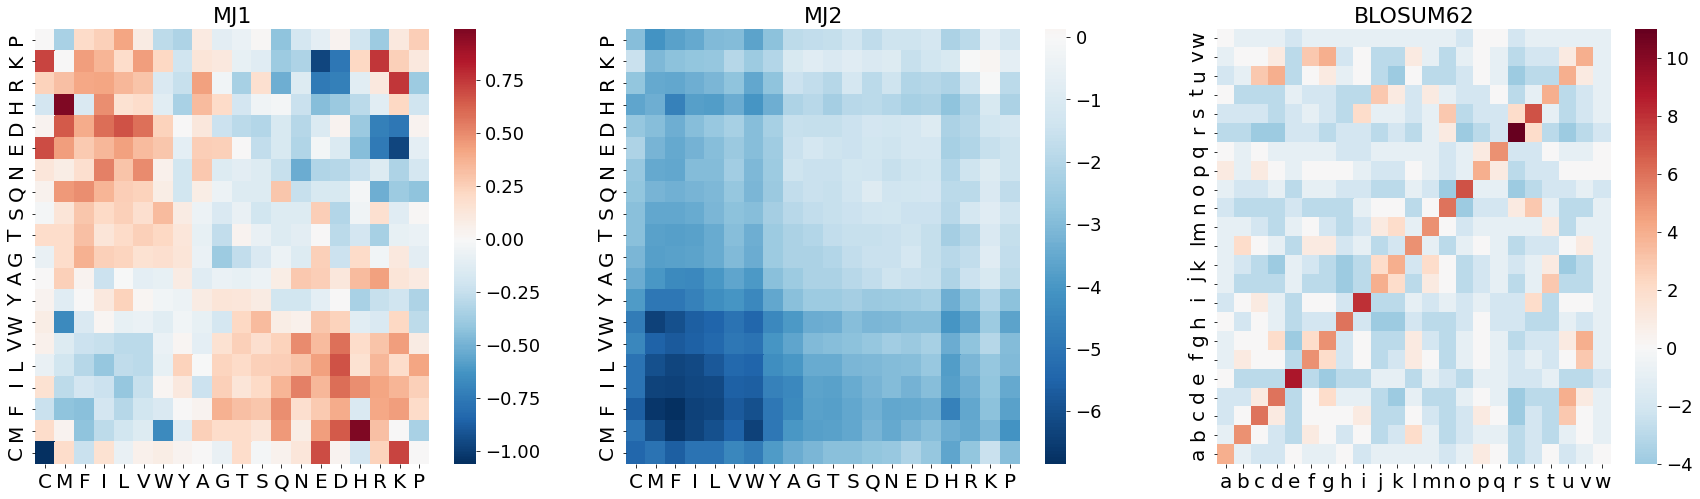

In [2]:
M1 = np.loadtxt(Text_files_path+'MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt(Text_files_path+'MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt(Text_files_path+'BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

## Single trajectory

In [268]:
L = 15
NC = 2e3
T0 = 0
Tf = 30
dT = 0.001
mu = 1
gamma = 0.0005
nu = 0.5
antigen = 'TACNSEYPNTTK'
antigen = 'FMLFMAVFVMTSWYC'
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
data_antigen = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/antigen_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_mu-%.1f_nu-%.1f_gamma-%.4f.txt'%(mu, nu, gamma))
data_bcells = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/bcells_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_mu-%.1f_nu-%.1f_gamma-%.4f.txt'%(mu, nu, gamma))
data_energies = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/energies_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'.txt')
data_N_active_linages = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/N_active_linages_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_mu-%.1f_nu-%.1f_gamma-%.4f.txt'%(mu, nu, gamma))
data_bcells_active = data_bcells[:,np.where(data_bcells[-1,:]!=1)[0]]


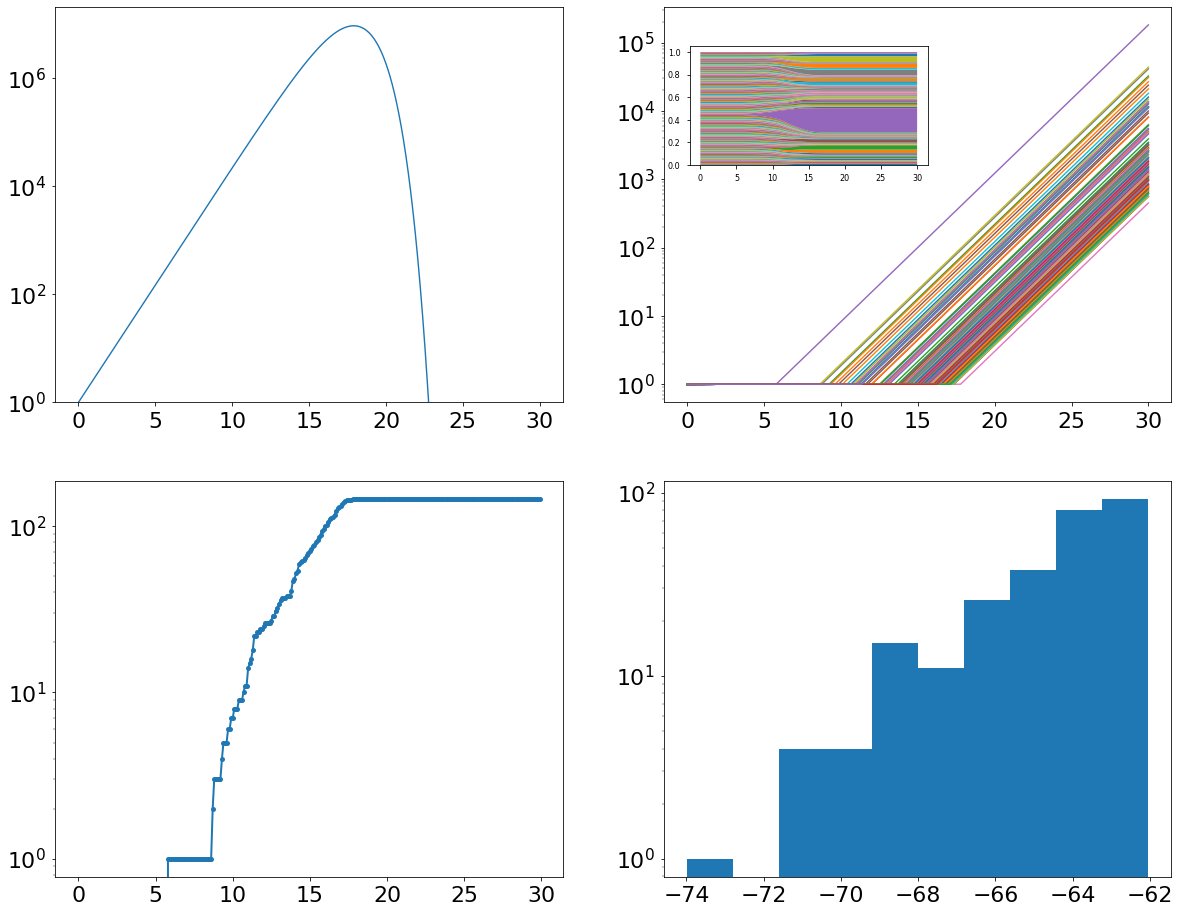

In [269]:
fig, ax = plt.subplots(2,2,figsize=(20,16))
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
ax[0,0].plot(time, data_antigen)
ax[0,0].set_yscale('log')
ax[0,0].tick_params(labelsize = 22)
ax[0,0].set_ylim(bottom = np.min(data_antigen[0]))

for i in range(int(data_N_active_linages[-1])):
    ax[0,1].plot(time, data_bcells_active[:,i]);
ax[0,1].set_yscale('log')
ax[0,1].tick_params(labelsize = 22)
axin1 = ax[0,1].inset_axes([0.05, .6, 0.47, 0.3])
axin1.stackplot(time, data_bcells_active.transpose()/np.sum(data_bcells_active.transpose(), axis = 0));

ax[1,0].plot(time[::100], data_N_active_linages[::100], linestyle = '-', marker = 'o', ms = 5, linewidth = 2, label = 'simulation')
ax[1,0].set_yscale('log')
ax[1,0].tick_params(labelsize = 22)

ax[1,1].hist(data_energies, bins = 10)
ax[1,1].set_yscale('log')
ax[1,1].tick_params(labelsize = 22)

In [5]:
np.exp(1*8)

2980.9579870417283

## Ensemble of trajectories

In [270]:
L = 15
NC = 2e3
T0 = 0
Tf = 25
dT = 0.01
mu = 1
gamma = .0005
nu = 0.5
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
data_bcells_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/bcells_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_mu-%.1f_nu-%.1f_gamma-%.4f.txt'%(mu, nu, gamma))
data_energies_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'.txt')
data_N_active_linages_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/N_active_linages_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_mu-%.1f_nu-%.1f_gamma-%.4f.txt'%(mu, nu, gamma))

print(len(data_bcells_ensemble))


154166


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


fit: -1.9845434918384877
theory: -2.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


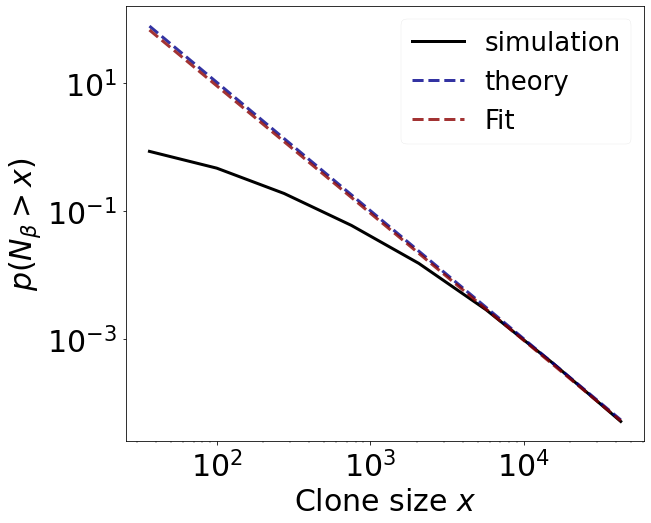

In [283]:
lambd = 1
#b = 1.62
#b = 1.97
#b = 2.08

clone_size_distribution = np.histogram(data_bcells_ensemble, bins = np.logspace(np.log10(np.min(data_bcells_ensemble)),np.log10(np.max(data_bcells_ensemble-1)),10), density = True)
#-------------------------
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})

clone_size = ((clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]+clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]))/2
clone_size_counts = clone_size_distribution[0][np.where(clone_size_distribution[0]!=0)]

delta_clone_size = clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]-clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]
cumsum_clone_size_counts = np.cumsum(clone_size_counts*delta_clone_size)

#-------------------------
popt, pcov = curve_fit(my_linear_func, np.log(clone_size[5:-1]), np.log(1-cumsum_clone_size_counts[5:-1]))
exponent_fit = popt[1]
print('fit:',exponent_fit)
#-------------------------
exponent = (-((mu*lambd)/nu))
plaw_fit = clone_size**(exponent)
plaw_fit /= (plaw_fit[-3]/(1-cumsum_clone_size_counts[-3]))
print('theory:' ,exponent)
#-------------------------
ax.plot(clone_size[:-1], 1-cumsum_clone_size_counts[:-1], color = 'k', linestyle = '-', marker = '', ms = 15, linewidth = 3, label = 'simulation')
ax.plot(clone_size[:-1], plaw_fit[:-1], linestyle = '--', marker = '', ms = 8, linewidth = 3, color='darkblue', label = 'theory', alpha = .8)
ax.plot(clone_size[:-1], np.exp(my_linear_func(np.log(clone_size[:-1]), *popt)), linestyle = '--', marker = '', ms = '10', linewidth = 3, color='darkred', label = 'Fit', alpha = .8)
#-------------------------
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Clone size $x$', fontsize = 30)
ax.set_ylabel(r'$p(N_{\beta}>x)$', fontsize = 30)
#ax.set_ylim(top=100)
ax.tick_params(labelsize = 30)
ax.legend(fontsize = 26)
fig.savefig('../Figures/1_Dynamics/Clone_size_distribution_example.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


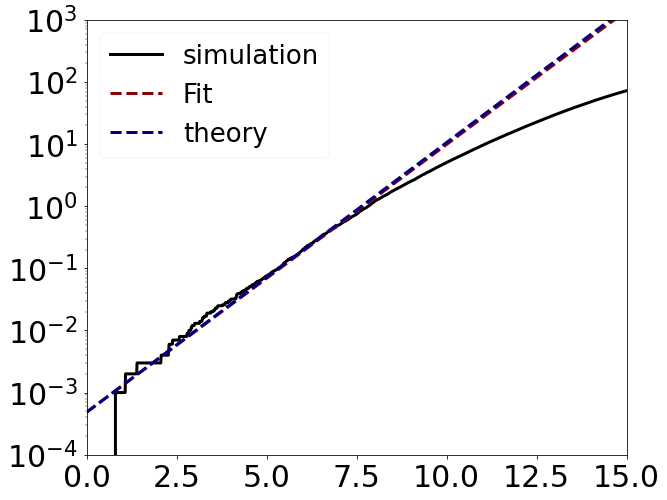

In [284]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.15})

exponent = (((mu*lambd)))
plaw_fit = np.exp(exponent*time[::])
plaw_fit /= (plaw_fit[700]/(1-data_N_active_linages_ensemble[700]))

exponent2 = -exponent_fit*nu
plaw_fit2 = np.exp(exponent2*time[::])
plaw_fit2 /= (plaw_fit2[700]/(1-data_N_active_linages_ensemble[700]))

ax.plot(time[::], data_N_active_linages_ensemble[::], color = 'k', linestyle = '-', marker = '', ms = 8, linewidth = 3, label = 'simulation')
ax.plot(time[::], plaw_fit2, color ='darkred', linestyle = '--', label = 'Fit', linewidth = 3)
ax.plot(time[::]-.05, plaw_fit, color ='darkblue', linestyle = '--', label = 'theory', linewidth = 3)
#-------------------------
#ax.set_xlabel(r'$t$', fontsize = 30)
#ax.set_ylabel(r'$m(t)$', fontsize = 30)
ax.set_yscale('log')
ax.set_xlim(T0, 15)
ax.set_ylim(1e-4, 1e3)
ax.tick_params(labelsize = 30)
ax.legend(fontsize = 26)
fig.savefig('../Figures/1_Dynamics/Activation_rate.eps')


-35.66 -43.6


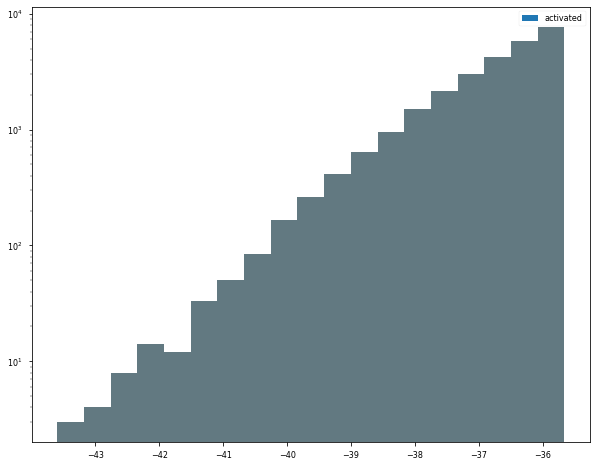

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(data_energies_ensemble[:,0][np.where(data_energies_ensemble[:,1]==1)], bins  = np.linspace(np.min(data_energies_ensemble[:,0]), np.max(data_energies_ensemble[:,0]),20), label = 'activated')
ax.hist(data_energies_ensemble[:,0], bins  = np.linspace(np.min(data_energies_ensemble[:,0]), np.max(data_energies_ensemble[:,0]),20), alpha = 0.3)
ax.legend(loc = 0)
print(np.max(data_energies_ensemble[:,0]), np.min(data_energies_ensemble[:,0]))
ax.set_yscale('log')


## $b(N)$

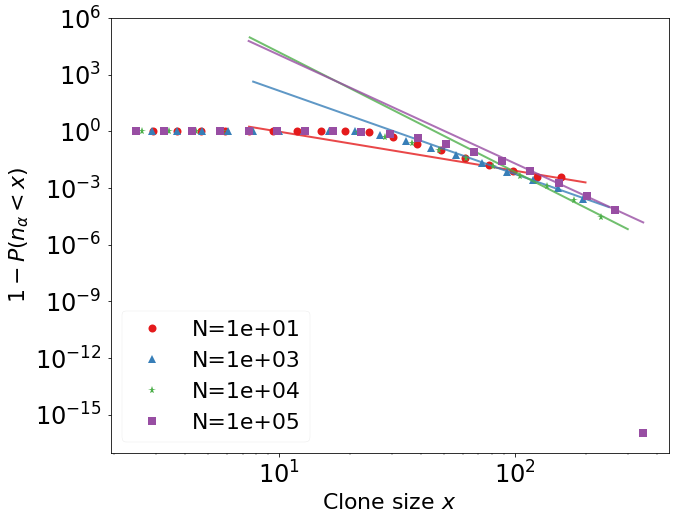

In [12]:
antigens = np.array(['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN'])
antigen = 'TACNSEYPNTTK'
T = .5
L = 12
#T0 = 14
#Tf = 22
T0 = 30
Tf = 60
dT = 0.01
beta = 1
gamma = .001
nu = 0.3
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
Ns_dynamics = np.array([1e1, 1e3, 1e4, 1e5])
markers = ['o', '^', '*', 's', 'X']
colors = plt.cm.Set1
exponents_csd = np.array([])
exponents_ds = np.array([])
vars_csd = np.array([])
vars_ds = np.array([])
fig, ax = plt.subplots(figsize = (10,8))
for k, N_dynamics in enumerate(Ns_dynamics):
    # ------- from clone size distribution -------
    data_bcells_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/bcells_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'_beta-%.1f_nu-%.1f_gamma-%.3f.txt'%(beta, nu, gamma))
    clone_size_distribution = np.histogram(data_bcells_ensemble, bins = np.logspace(np.log10(np.min(data_bcells_ensemble))-1,np.log10(np.max(data_bcells_ensemble)),20), density = True)
    clone_size = (clone_size_distribution[1][:-1]+clone_size_distribution[1][1:])/2
    clone_size_counts = clone_size_distribution[0]

    delta_clone_size = clone_size_distribution[1][1:]-clone_size_distribution[1][:-1]
    cumsum_clone_size_counts = np.cumsum(clone_size_counts*delta_clone_size)
    ax.plot(clone_size[:], 1-cumsum_clone_size_counts[:], linestyle = '', marker = markers[k], ms = 8, linewidth = 2, label = 'N=%.e'%(N_dynamics), color = plt.cm.Set1(k))

    popt_csd, pcov_csd = curve_fit(my_linear_func, np.log(clone_size[np.where((1-cumsum_clone_size_counts)!=1)][-5:-1]), np.log(1-cumsum_clone_size_counts[np.where((1-cumsum_clone_size_counts)!=1)][-5:-1]))
    
    exponents_csd = np.append(exponents_csd, popt_csd[1])
    vars_csd = np.append(vars_csd, pcov_csd[1,1])
    
    ax.plot(clone_size[4:], np.exp(my_linear_func(np.log(clone_size[4:]), *popt_csd)), linestyle = '-', marker = '', ms = '10', linewidth = 2, color=plt.cm.Set1(k), alpha= .8)


    # ------- from density of sequences -------
    data_dynamics_tail=np.loadtxt(Text_files_path + 'Dynamics/ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'.txt')
    data_dynamics_tail_rho = np.histogram(data_dynamics_tail[:,0], bins = 8, density = False) # Creating histograms
    e_dynamics_tail = data_dynamics_tail_rho[1][:-1] + abs(data_dynamics_tail_rho[1][1:]-data_dynamics_tail_rho[1][:-1])/2
    rho_e_dynamics_tail = data_dynamics_tail_rho[0]*1e8
    e_lineal = e_dynamics_tail[:4]
    rho_e_lineal = rho_e_dynamics_tail[:4]
    popt_ds, pcov_ds = curve_fit(my_linear_func, e_lineal, np.log(rho_e_lineal), p0 = (60,1))
    
    exponents_ds = np.append(exponents_ds, (popt_ds[1]*beta)/nu)
    vars_ds = np.append(vars_ds, pcov_ds[1,1])
    
    
ax.set_xlabel('Clone size $x$', fontsize = 22)
ax.set_ylabel(r'$1-P(n_{\alpha}<x)$', fontsize = 22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize = 24)
ax.legend(fontsize = 22, loc = 0)
#fig.savefig('../Figures/1_Dynamics/Clone_size_distribution_N.png')


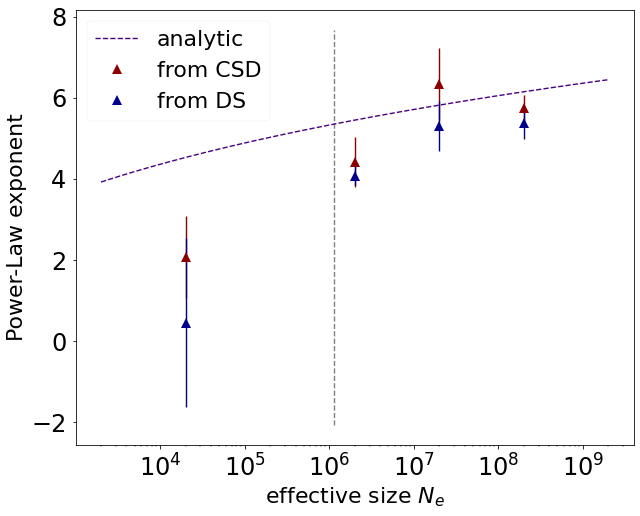

In [13]:
mean_e =-28.945951714884234
var_e = 9.378153782122688
N_array=np.logspace(0, 6, 100)
N_ensemble = 2e3
e = np.linspace(-45.5, -40.2, 5)
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(N_array*N_ensemble, ((-1*((-np.exp(3.5)*(np.log10(N_array*N_ensemble)**(0.15770589)))-mean_e)/(var_e))*beta/nu), linestyle = '--', color = 'indigo', label = 'analytic')
ax.plot(Ns_dynamics*N_ensemble, -exponents_csd, marker = '^', color = 'darkred', linestyle = '', ms = 10, label = 'from CSD')
ax.errorbar(x = Ns_dynamics*N_ensemble, y = -exponents_csd, yerr = 1.96*np.sqrt(vars_csd), color = 'darkred', linestyle = '', capsize = 4)
ax.plot(Ns_dynamics*N_ensemble, exponents_ds, marker = '^', color = 'darkblue', linestyle = '', ms = 10, label = 'from DS')
ax.errorbar(x = Ns_dynamics*N_ensemble, y = exponents_ds, yerr = 1.96*(np.sqrt(vars_ds)*beta)/nu, color = 'darkblue', linestyle = '', capsize = 4)
ax.vlines(10**((44/np.exp(3.5))**(1/0.15770589)), ax.get_ylim()[0], ax.get_ylim()[1], linestyle = 'dashed', color = 'grey')

ax.set_xlabel('effective size $N_{e}$', fontsize = 22)
ax.set_ylabel('Power-Law exponent', fontsize = 22)
ax.tick_params(labelsize = 24)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize = 22, loc = 0)
#fig.savefig('../Figures/1_Dynamics/Exponent_clone_size_distribution_N.png')

In [3]:
%%time
n_seq = 500000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")



CPU times: user 3.28 s, sys: 318 ms, total: 3.6 s
Wall time: 3.44 s


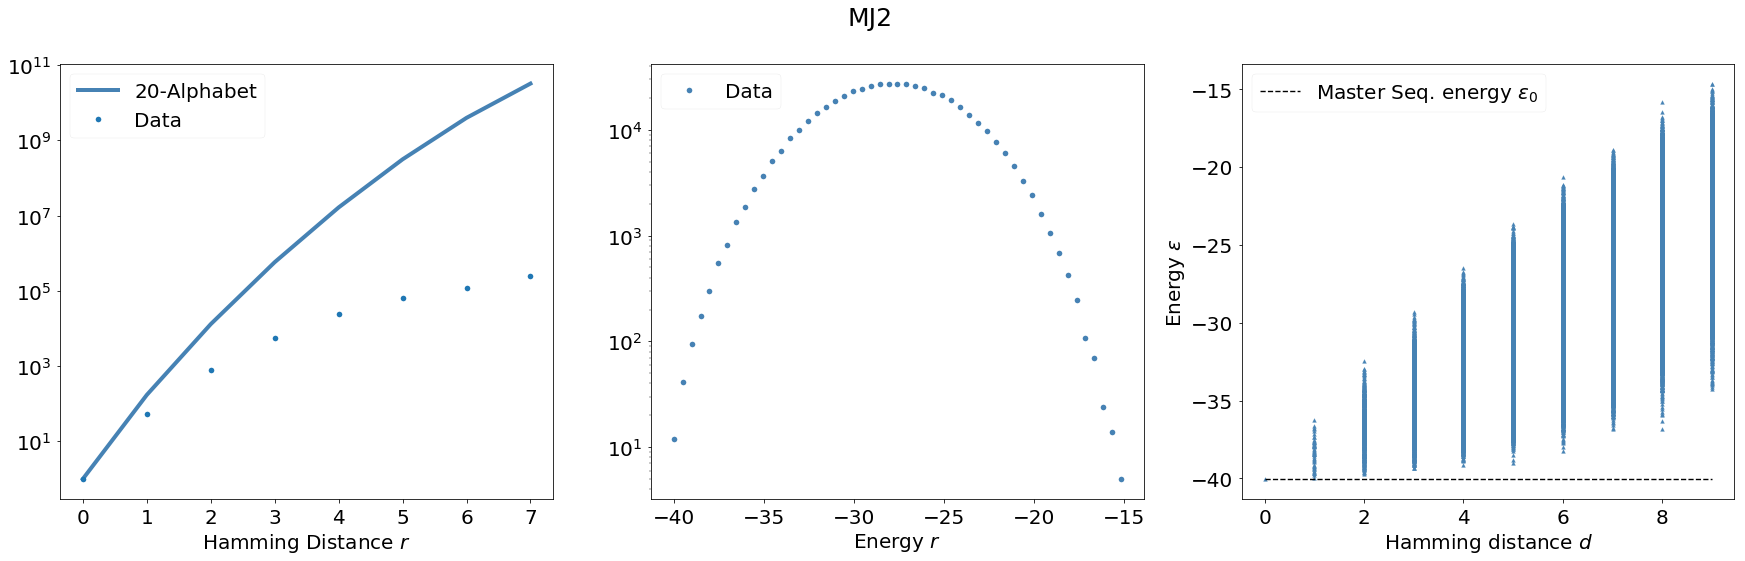

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle('MJ2', fontsize = 25)
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies, data_energies = plot_histogram_energy(Sequences = Sequences, bins = 51, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences_MJ2-n_seq-%d.png'%(n_seq))


(-40.03, -35.03)

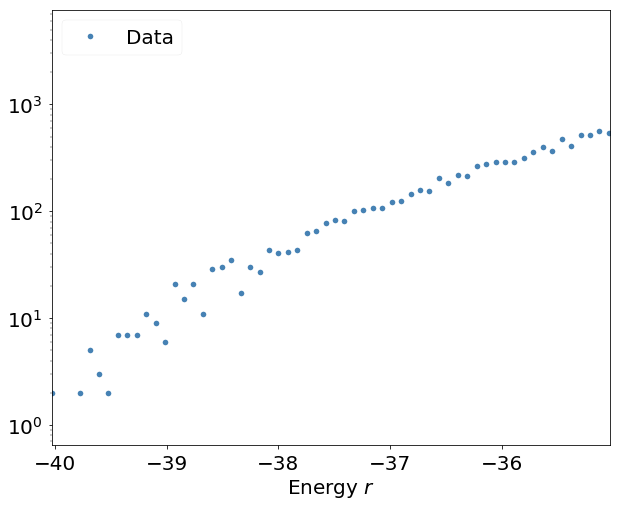

# Deterministic Simulation

In [52]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 1
R=6
beta = 1
gamma = 1
T = 25
master_Sequence_energy = 0
dt = 0.002
Sub_Sequences = np.random.choice(Sequences, n_linages)
for i in range(n_linages):
    Sub_Sequences[i].active = False
Model  = Deterministic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma, 
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy, 
                                  dt = dt)
Model.ODE()


CPU times: user 12.6 s, sys: 43 ms, total: 12.6 s
Wall time: 12.7 s


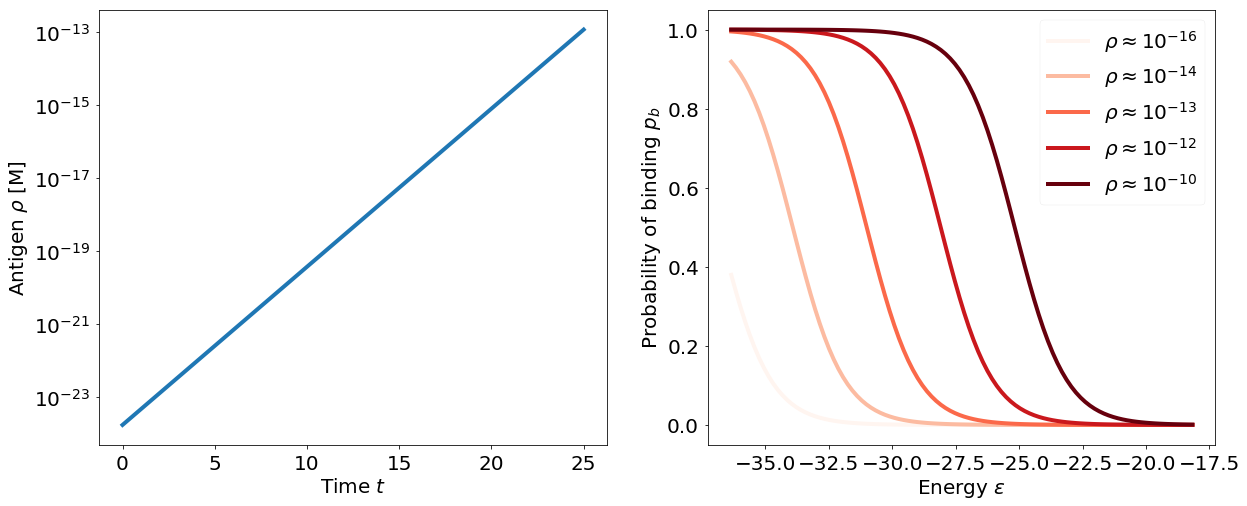

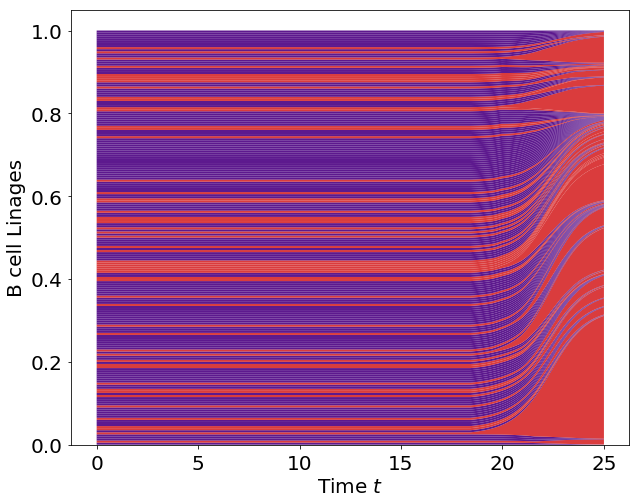

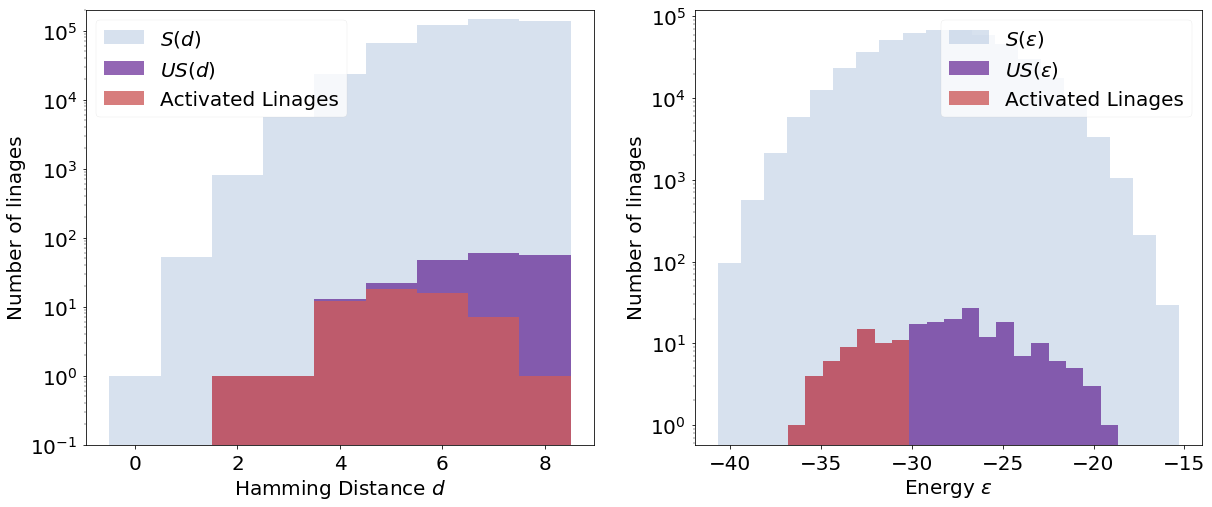

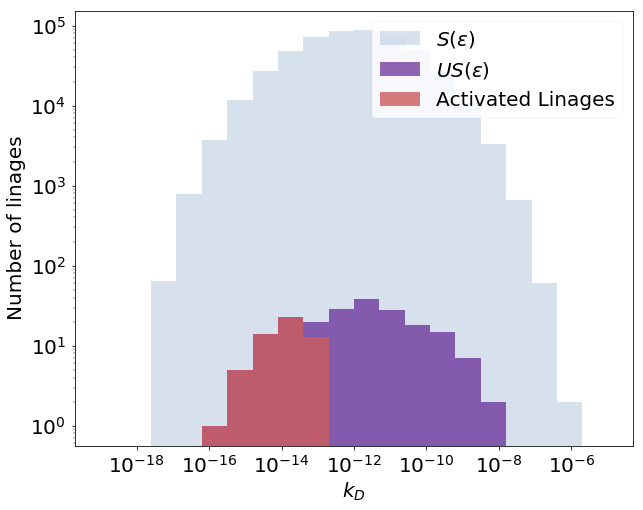

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.plot_antigen_time(ax = ax[0])
Model.plot_prob_binding(ax = ax[1])
ax[1].set_yscale('linear')
counter = 0
while(os.path.isfile('../Figures/Antigen_Binding_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Antigen_Binding_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.stackplot_linages_time(antigen = False, time = True, ax = ax)
counter = 0
while(os.path.isfile('../Figures/Linages_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Linages_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[1])
counter = 0
while(os.path.isfile('../Figures/Histograms_hamming_energy_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Histograms_hamming_energy_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.hist_sequences_k_D(Sequences = Sequences, bins = np.logspace(-19, -5, 21), ax = ax)
ax.set_xscale('log')
ax.set_xlabel(r'$k_D$', fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/Histogram_k_D_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Histogram_k_D_%d.png'%(0))


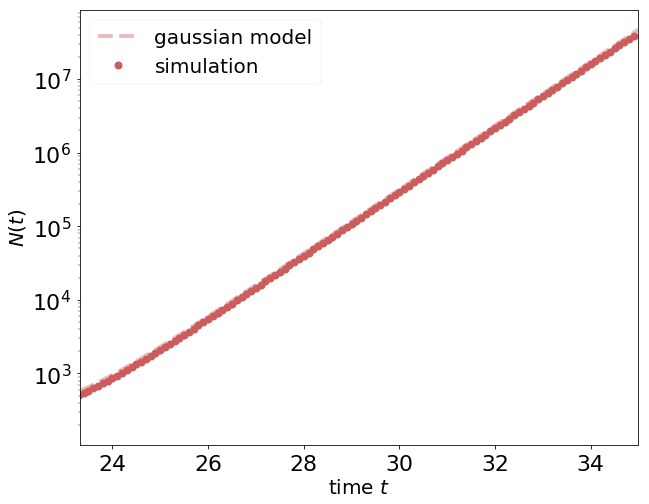

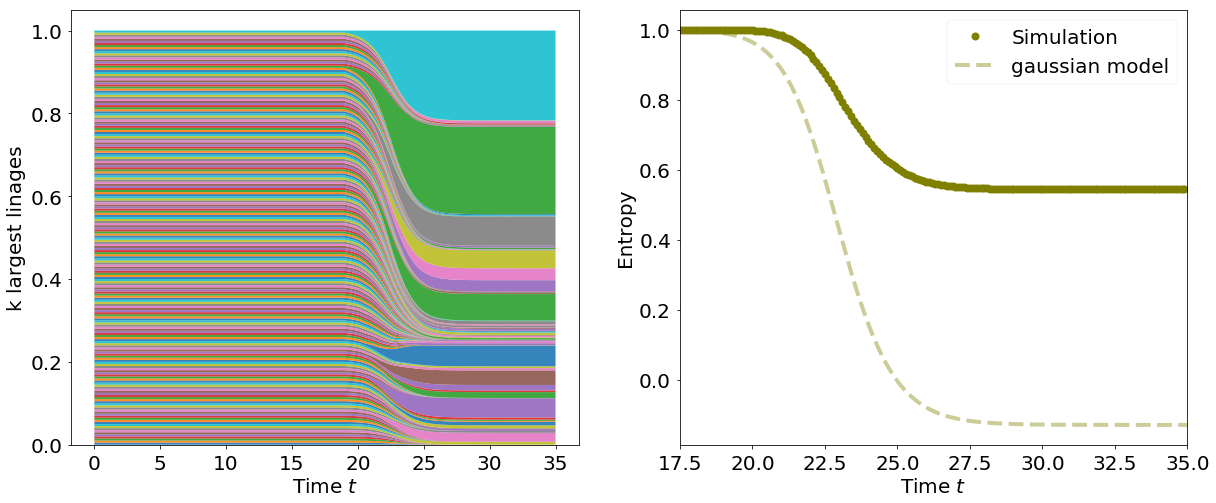

In [26]:
popt = np.array([ 1.35847161e+05, -4.92212036e-02, -2.79453873e+01])

fig, ax = plt.subplots(1,1,figsize=(10,8))
t_new = np.linspace(0, T, int(T/dt))
N_total = np.array([np.cumsum(np.exp(t-np.linspace(0,t, 100))*(1.7e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] + 200 - np.cumsum((2e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] for t in t_new])
ax.plot(t_new, N_total, linestyle = '--', linewidth = 4, color = 'indianred', alpha = 0.4, label = 'gaussian model')
ax.plot(Model.time_series[::50], np.sum(Model.linages_time_series, axis=0)[::50], marker = 'o', ms = 8, color = 'indianred', linestyle = '', label = 'simulation')
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'$N(t)$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_yscale('log')
ax.set_xlim(2*T/3, T)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/N_total_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/N_total_%d.png'%(0))

#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
t_new = np.linspace(0, T, int(T/dt))

N_alpha_log_N_alpha = np.array([np.cumsum((np.exp(t-np.linspace(0,t, 100))*(t-np.linspace(0,t, 100))*(1.7e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt)))*(t/100))[-1] for t in t_new])

biggest_k_linages_freq = Model.plot_k_largest_linages(k=200, ax=ax[0])
Model.plot_normalized_entropy_k_largest_linages(k=200, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[1])

ax[1].plot(t_new, ((-1/N_total)*(N_alpha_log_N_alpha) + np.log(N_total))/np.log(n_linages), linestyle = '--', linewidth = 4, color = 'olive', alpha = 0.4, label = 'gaussian model')
ax[1].legend(loc = 0, fontsize = 20)
ax[1].set_xlim(1*T/2, T)
counter = 0
while(os.path.isfile('../Figures/Entropy__%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Entropy__%d.png'%(0))


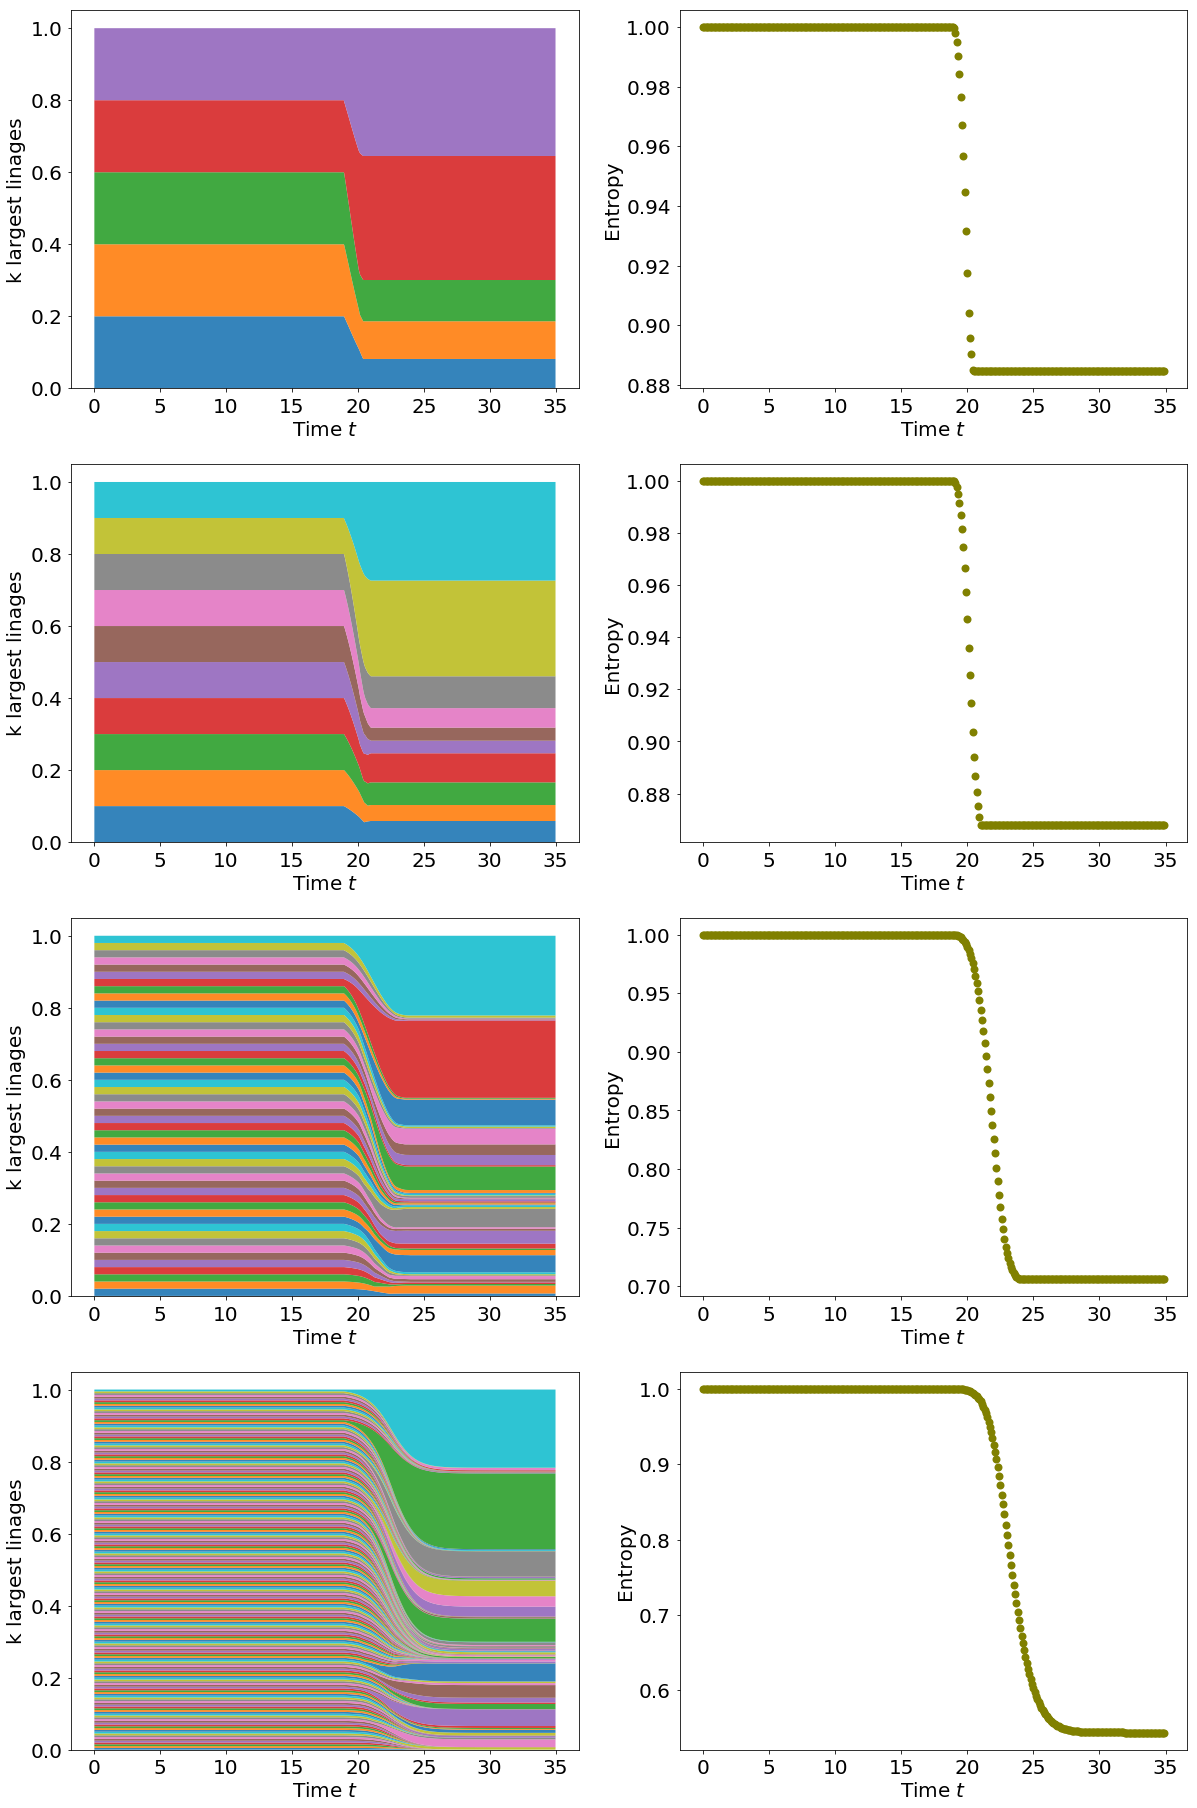

In [9]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

entropy_drop = np.array([0])
k_array = np.array([0, 5, 10, 50, 200])
for i, k in enumerate(k_array[1:]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    normalized_entropy = Model.plot_normalized_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])
    entropy_drop = np.append(entropy_drop, normalized_entropy[-1] - normalized_entropy[0])
    
counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(0))

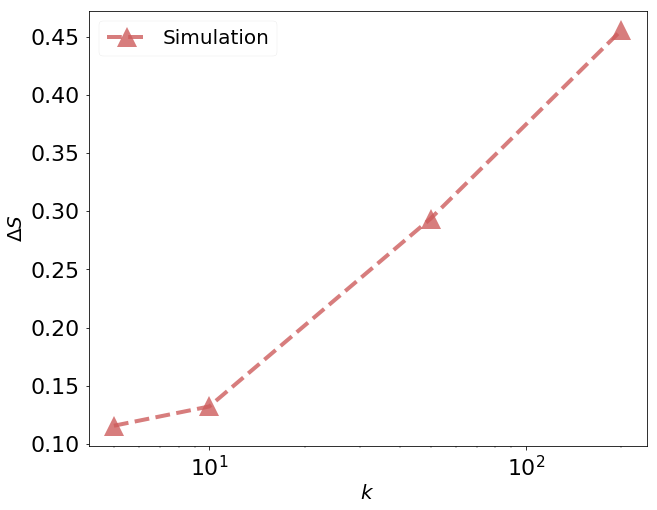

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(k_array[1:], abs(entropy_drop)[1:], linestyle = '--', marker = '^', ms = 20, linewidth = 4, color = 'indianred', alpha = 0.8, label = 'Simulation')
ax.set_xlabel(r'$k$', fontsize = 20)
ax.set_ylabel(r'$\Delta S$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_xscale('log')
#ax.set_ylim(0.1,1)
#ax.set_xlim(,n_linages*2)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/Entropy_drop_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Entropy_drop_%d.png'%(0))


In [47]:
Sequences_tree = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(10000), "rb" ) )

In [49]:
np.min([Sequences_tree[i].energy for i in range(10000)])

-42.66

## Stochastic Simulation - Stochastic antigen dynamics

In [ ]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.0004
R=6
beta = 0.001
gamma = 1
T = 5
master_Sequence_energy = 0
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
Model.Gillespie()



## Plot linages

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


## entropy

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))


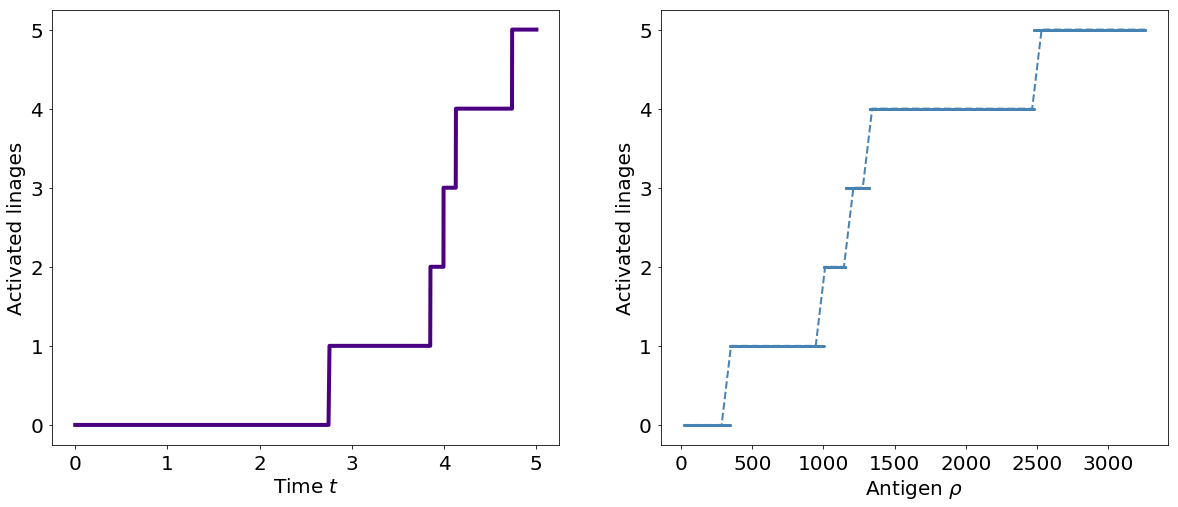

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(20, np.max(Model.antigen_time_series), 50)

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



In [1]:
a = 4

In [3]:
2*(3>a)

0

In [64]:
antigen = 1e8/N_A
display(Math(r'\textrm{Antigen concentration = }%.2e M'%(antigen)))
k_D = np.exp(Sequences[10].energy)
display(Math(r'\epsilon=%.3f'%(Sequences[10].energy)))
display(Math((r'$k_D=%.2e$'%(k_D))))
display(Math(r'f=%.6f'%(antigen/(antigen+k_D))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1.6605390671738466e-15

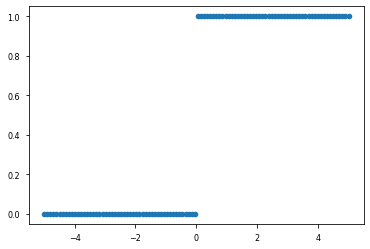

In [17]:
x = np.linspace(-5,5,100)
plt.plot(x, np.heaviside(x,1), 'o')

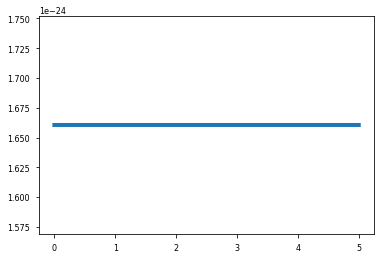

In [10]:
plt.plot(Model.time_series, np.transpose(Model.antigen_time_series)/N_A, linewidth  = 4)

In [15]:
Model.antigen_time_series[0,0:2]

array([1., 1.])